# Evaluate latency on Wi-SUN emulator

In [12]:
from scapy.all import *
import asyncio
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from SimTelemetry import SimTelemetry

In [13]:
SUBNET = 'fd12:3456::302:304:506:'
SRC_HOST = 'fd12:3456::eba9:3a82:1f86:9829'
reference_file = 'simulation/topologies_2024-11-13 09_22_57.587218_simulation.csv'

In [3]:
!python EmulatorConvertor.py -f "{reference_file}"

Write to path ../wisun-mbed-simulator


## Statistic ICMPv6 flooding on Emulator

In [14]:
conf.raw_layer = IPv6 # Required in order to receive reply for ICMPv6

In [15]:
NB_NODES = 15
PACKET_PER_DST = 10
INTERVAL = 0.1
TIMEOUT = None

In [5]:
targets = [f'{SUBNET}{id:x}' for id in range(NB_NODES)]
ans, unans = srloop(IPv6(dst=targets)/ICMPv6EchoRequest(), inter=INTERVAL, count=PACKET_PER_DST, timeout=TIMEOUT, iface='tun0', verbose=False)
nodes_tracking = {host: {'latencies': [], 'icmp_success': 0, 'icmp_fail': 0} for host in targets}
for entry in ans:
    icmp_req = entry[0]
    icmp_resp = entry[1]
    nodes_tracking[icmp_req.dst]['latencies'].append(icmp_resp.time - icmp_req.sent_time)
    nodes_tracking[icmp_req.dst]['icmp_success'] += 1

for entry in unans:
    nodes_tracking[entry.dst]['icmp_fail'] += 1
print("Average icmp latency per node:")
for node_ip, node_data in nodes_tracking.items():
    print(f"Node ID: {int(node_ip.split(':')[-1], 16)}")
    print(f"    IPv6 : {node_ip}")
    print(f"    Average latency : {sum(node_data['latencies']) / len(node_data['latencies']) if len(node_data['latencies']) > 0 else 0.0}")
    print(f"    ICMP success : {node_data['icmp_success']}")
    print(f"    ICMP fail : {node_data['icmp_fail']}")


Average icmp latency per node:
Node ID: 0
    IPv6 : fd12:3456::302:304:506:0
    Average latency : 0.0062511682510375975
    ICMP success : 10
    ICMP fail : 0
Node ID: 1
    IPv6 : fd12:3456::302:304:506:1
    Average latency : 0.3515808582305908
    ICMP success : 4
    ICMP fail : 6
Node ID: 2
    IPv6 : fd12:3456::302:304:506:2
    Average latency : 1.128859281539917
    ICMP success : 4
    ICMP fail : 6
Node ID: 3
    IPv6 : fd12:3456::302:304:506:3
    Average latency : 0.7074388027191162
    ICMP success : 5
    ICMP fail : 5
Node ID: 4
    IPv6 : fd12:3456::302:304:506:4
    Average latency : 1.446524477005005
    ICMP success : 5
    ICMP fail : 5
Node ID: 5
    IPv6 : fd12:3456::302:304:506:5
    Average latency : 1.5616868223462785
    ICMP success : 7
    ICMP fail : 3
Node ID: 6
    IPv6 : fd12:3456::302:304:506:6
    Average latency : 1.255449390411377
    ICMP success : 5
    ICMP fail : 5
Node ID: 7
    IPv6 : fd12:3456::302:304:506:7
    Average latency : 1.68958801

In [16]:
# Function to send ICMPv6 echo requests
def flood_icmpv6(targets, inter, count):
    packets = IPv6(dst=targets)/ICMPv6EchoRequest()
    send(packets, inter=inter, count=count, verbose=False, iface='tun0')  # Flood with ICMPv6 packets

# Function to sniff ICMPv6 echo replies
def sniff_responses(timeout):
    filter_exp = f"icmp6 and ip6[40] == 129"  # ICMPv6 Echo Reply filter
    responses = sniff(filter=filter_exp, timeout=timeout, count=0, iface='tun0')
    return responses

# Async wrapper to send packets
async def async_send_flood(targets, inter, count, loop):
    await loop.run_in_executor(None, flood_icmpv6, targets, inter, count)

# Async wrapper to sniff responses
async def async_sniff_responses(timeout, loop):
    responses = await loop.run_in_executor(None, sniff_responses, timeout)
    return responses

# Main async function
async def run_icmpv6_test(targets, host_src, inter, send_count, sniff_timeout):
    loop = asyncio.get_event_loop()

    # Start the flooding
    total_send = len(targets) * send_count
    print(f"Flooding {total_send} ICMPv6 packets...")
    await async_send_flood(targets, inter, send_count, loop)

    # Start sniffing for responses
    print("Sniffing for responses...")
    responses = await async_sniff_responses(host_src, sniff_timeout, loop)

    # Print the received responses
    total_ans = len(responses)
    total_unans = total_send - total_ans
    print(f"Received : {total_ans}")
    print(f"Not answered : {total_unans}")

In [7]:
targets = [f'{SUBNET}{id:x}' for id in range(NB_NODES)]
timeout_sniff = 15
nb_packets = 1
loop = asyncio.get_event_loop()
print("Create Flood task")
flood_task = loop.create_task(async_send_flood(targets, INTERVAL, nb_packets, loop))
print("Create Sniff task")
sniff_task = loop.create_task(async_sniff_responses(timeout_sniff, loop))
#task = loop.create_task(run_icmpv6_test(targets, SRC_HOST,INTERVAL, 1,timeout_sniff))
await flood_task
responses = await sniff_task
# Print the received responses
total_send = len(targets) * nb_packets
total_ans = len(responses)
total_unans = total_send - total_ans
print(f"Total send : {total_send}")
print(f"Received : {total_ans}")
print(f"Not answered : {total_unans}")

Create Flood task
Create Sniff task
Total send : 15
Received : 0
Not answered : 15


In [6]:
targets = [f'{SUBNET}{id:x}' for id in range(NB_NODES)]
timeout_sniff = 15
all_ans = []
all_unans = []
all_n_packets = list(range(1,30,2))
for n_packets in all_n_packets:
    loop = asyncio.get_event_loop()
    print("Create Flood task")
    flood_task = loop.create_task(async_send_flood(targets, INTERVAL, n_packets, loop))
    print("Create Sniff task")
    sniff_task = loop.create_task(async_sniff_responses(timeout_sniff, loop))
    #task = loop.create_task(run_icmpv6_test(targets, SRC_HOST,INTERVAL, 1,timeout_sniff))
    await flood_task
    responses = await sniff_task
    # Print the received responses
    total_send = len(targets) * n_packets
    total_ans = len(responses)
    total_unans = total_send - total_ans
    all_ans.append(total_ans)
    all_unans.append(total_unans)

Create Flood task
Create Sniff task
Create Flood task
Create Sniff task
Create Flood task
Create Sniff task
Create Flood task
Create Sniff task
Create Flood task
Create Sniff task
Create Flood task
Create Sniff task
Create Flood task
Create Sniff task
Create Flood task
Create Sniff task
Create Flood task
Create Sniff task
Create Flood task
Create Sniff task
Create Flood task
Create Sniff task
Create Flood task
Create Sniff task
Create Flood task
Create Sniff task
Create Flood task
Create Sniff task
Create Flood task
Create Sniff task


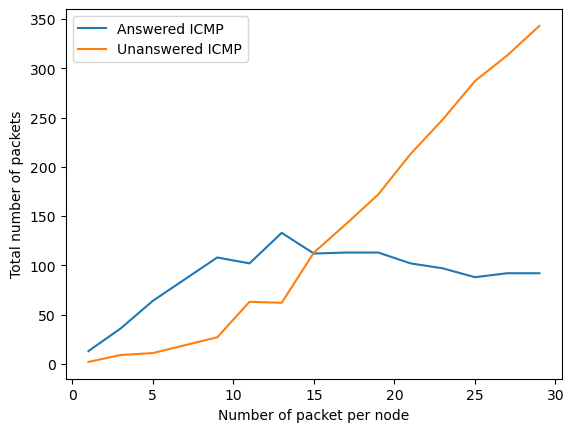

In [7]:
plt.figure()
plt.plot(all_n_packets, all_ans, label="Answered ICMP")
plt.plot(all_n_packets, all_unans, label="Unanswered ICMP")
plt.xlabel("Number of packet per node")
plt.ylabel("Total number of packets")
plt.legend()
plt.show()

In [8]:
print("Ratio success/fail transmission")
for i,n in enumerate(all_n_packets):
    print(f"For {n} packets : {all_ans[i]/all_unans[i]}")

Ratio success/fail transmission
For 1 packets : 6.5
For 3 packets : 4.0
For 5 packets : 5.818181818181818
For 7 packets : 4.526315789473684
For 9 packets : 4.0
For 11 packets : 1.619047619047619
For 13 packets : 2.1451612903225805
For 15 packets : 0.9911504424778761
For 17 packets : 0.795774647887324
For 19 packets : 0.6569767441860465
For 21 packets : 0.4788732394366197
For 23 packets : 0.3911290322580645
For 25 packets : 0.30662020905923343
For 27 packets : 0.2939297124600639
For 29 packets : 0.26822157434402333


## Validation

In [9]:
df_ref = pd.read_csv(Path(reference_file),index_col='node_id')
df_ref

,node_type,rank,parent,rssi,tx_success,tx_failure,collision_avoided,neighbors
node_id,,,,,,,,
0,BR,0,-1,-1.000000,2100,2974,0,4:0.2821601784283215;8:0.20311364761725756;12:...
1,NODE,6,11,0.339461,150,279,0,5:0.3326150670215229;6:0.2814085083421618;10:0...
2,NODE,7,9,0.604525,150,97,0,7:0.38551061603259695;9:0.6045247768847164;13:...
3,NODE,5,13,0.192942,150,540,0,6:0.37920551404944586;13:0.19294229393176757
4,NODE,7,9,0.518289,450,665,0,0:0.2821601784283215;7:0.2796021963087897;9:0....
5,NODE,2,12,0.400273,150,203,0,1:0.3326150670215229;10:0.3851156470912966;12:...
6,NODE,4,14,0.327711,150,264,0,1:0.2814085083421618;3:0.37920551404944586;14:...
7,NODE,8,4,0.279602,150,461,0,2:0.38551061603259695;4:0.2796021963087897;11:...
8,NODE,2,12,0.217931,3150,7248,0,0:0.20311364761725756;12:0.21793072665592383;1...


### Run multiple time with emulator

In [10]:
targets = [f'{SUBNET}{id:x}' for id in range(NB_NODES)]
timeout_sniff = 15
all_ans = []
all_unans = []
n_packets = 15
n_iters = 10
for i in range(n_iters):
    loop = asyncio.get_event_loop()
    print("Create Flood task")
    flood_task = loop.create_task(async_send_flood(targets, INTERVAL, n_packets, loop))
    print("Create Sniff task")
    sniff_task = loop.create_task(async_sniff_responses(timeout_sniff, loop))
    #task = loop.create_task(run_icmpv6_test(targets, SRC_HOST,INTERVAL, 1,timeout_sniff))
    await flood_task
    responses = await sniff_task
    # Print the received responses
    total_send = len(targets) * n_packets
    total_ans = len(responses)
    total_unans = total_send - total_ans
    all_ans.append(total_ans)
    all_unans.append(total_unans)

Create Flood task
Create Sniff task
Create Flood task
Create Sniff task
Create Flood task
Create Sniff task
Create Flood task
Create Sniff task
Create Flood task
Create Sniff task
Create Flood task
Create Sniff task
Create Flood task
Create Sniff task
Create Flood task
Create Sniff task
Create Flood task
Create Sniff task
Create Flood task
Create Sniff task


In [11]:
print(f"Reference ratio success/fail : {df_ref['tx_success'].sum()/df_ref['tx_failure'].sum()}")
print(f"Emulator ratio success/fail : {sum(all_ans)/sum(all_unans)}")

Reference ratio success/fail : 0.5149929396129247
Emulator ratio success/fail : 0.9667832167832168
